In [2]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.stats import zscore
from skimage.exposure import adjust_gamma
from skimage.filters import threshold_local
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
import tiffslide as openslide
def coordinate_pairs(v1,v2):
    for i in v1:
        for j in v2:
            yield i,j
def deconvolution(img,MOD):
    MODx=MOD[0]
    MODy=MOD[1]
    MODz=MOD[2]
    cosx=np.zeros((3,))
    cosy=np.zeros((3,))
    cosz=np.zeros((3,))
    len=np.zeros((3,))
    for i in range(0,3):
        cosx[i]=cosy[i]=cosz[i]=0.0
        len[i]=np.sqrt(MODx[i]*MODx[i] + MODy[i]*MODy[i] + MODz[i]*MODz[i])
        if len[i]!=0.0:
            cosx[i]= MODx[i]/len[i]
            cosy[i]= MODy[i]/len[i]
            cosz[i]= MODz[i]/len[i]

    if cosx[1]==0.0:
        if cosy[1]==0.0:
            if cosz[1]==0.0:
                cosx[1]=cosz[0]
                cosy[1]=cosx[0]
                cosz[1]=cosy[0]

    if cosx[2]==0.0:
    	if cosy[2]==0.0:
    		if cosz[2]==0.0:
    			if ((cosx[0]*cosx[0] + cosx[1]*cosx[1])> 1):
    				cosx[2]=0.0
    			else:
    				cosx[2]=np.sqrt(1.0-(cosx[0]*cosx[0])-(cosx[1]*cosx[1]))

    			if ((cosy[0]*cosy[0] + cosy[1]*cosy[1])> 1):
    				cosy[2]=0.0
    			else:
    				cosy[2]=np.sqrt(1.0-(cosy[0]*cosy[0])-(cosy[1]*cosy[1]))

    			if ((cosz[0]*cosz[0] + cosz[1]*cosz[1])> 1):
    				cosz[2]=0.0
    			else:
    				cosz[2]=np.sqrt(1.0-(cosz[0]*cosz[0])-(cosz[1]*cosz[1]))
    leng= np.sqrt(cosx[2]*cosx[2] + cosy[2]*cosy[2] + cosz[2]*cosz[2])

    cosx[2]= cosx[2]/leng
    cosy[2]= cosy[2]/leng
    cosz[2]= cosz[2]/leng


    A = cosy[1] - cosx[1] * cosy[0] / cosx[0]
    V = cosz[1] - cosx[1] * cosz[0] / cosx[0]
    C = cosz[2] - cosy[2] * V/A + cosx[2] * (V/A * cosy[0] / cosx[0] - cosz[0] / cosx[0])
    q=np.zeros((9,))
    q[2] = (-cosx[2] / cosx[0] - cosx[2] / A * cosx[1] / cosx[0] * cosy[0] / cosx[0] + cosy[2] / A * cosx[1] / cosx[0]) / C;
    q[1] = -q[2] * V / A - cosx[1] / (cosx[0] * A);
    q[0] = 1.0 / cosx[0] - q[1] * cosy[0] / cosx[0] - q[2] * cosz[0] / cosx[0];
    q[5] = (-cosy[2] / A + cosx[2] / A * cosy[0] / cosx[0]) / C;
    q[4] = -q[5] * V / A + 1.0 / A;
    q[3] = -q[4] * cosy[0] / cosx[0] - q[5] * cosz[0] / cosx[0];
    q[8] = 1.0 / C;
    q[7] = -q[8] * V / A;
    q[6] = -q[7] * cosy[0] / cosx[0] - q[8] * cosz[0] / cosx[0];

    img_stain1 = np.ravel(np.copy(img[:,:,0]))
    img_stain2 = np.ravel(np.copy(img[:,:,1]))
    img_stain3 = np.ravel(np.copy(img[:,:,2]))
    dims=img.shape
    imagesize = dims[0] * dims[1]
    rvec=np.ravel(np.copy(img[:,:,0])).astype('float')
    gvec=np.ravel(np.copy(img[:,:,1])).astype('float')
    bvec=np.ravel(np.copy(img[:,:,2])).astype('float')
    log255=np.log(255.0)
    for i in range(0,imagesize):
        R = rvec[i]
        G = gvec[i]
        B = bvec[i]

        Rlog = -((255.0*np.log((R+1)/255.0))/log255)
        Glog = -((255.0*np.log((G+1)/255.0))/log255)
        Blog = -((255.0*np.log((B+1)/255.0))/log255)
        for j in range(0,3):
            Rscaled = Rlog * q[j*3];
            Gscaled = Glog * q[j*3+1];
            Bscaled = Blog * q[j*3+2];

            output = np.exp(-((Rscaled + Gscaled + Bscaled) - 255.0) * log255 / 255.0)
            if(output>255):
                output=255

            if j==0:
                img_stain1[i] = np.floor(output+.5)
            elif j==1:
                img_stain2[i] = np.floor(output+.5)
            else:
            	img_stain3[i] = np.floor(output+.5)
    img_stain1=np.reshape(img_stain1,(dims[0],dims[1]))
    img_stain2=np.reshape(img_stain2,(dims[0],dims[1]))
    img_stain3=np.reshape(img_stain3,(dims[0],dims[1]))
    return img_stain1,img_stain2,img_stain3



def deconvolution_WSI(img_path,MOD,block_size):
    slide=openslide.OpenSlide(img_path)
    dim_x,dim_y=slide.dimensions
    # slide.close()
    index_x=np.array(range(0,dim_x,block_size))
    index_y=np.array(range(0,dim_y,block_size))
    img_stain1=np.zeros((dim_y,dim_x))
    img_stain2=np.zeros((dim_y,dim_x))
    img_stain3=np.zeros((dim_y,dim_x))
    totalpatches=len(index_x)*len(index_y)

    # deconv_images=Parallel(n_jobs=multiprocessing.cpu_count())(delayed(deconvolution)(np.array(slide.read_region((i,j),
    #     0,(min(dim_y,i+block_size)-i,min(dim_x,j+block_size)-j)))[:,:,:3],MOD) for i in tqdm(index_y) for j in index_x)
    deconv_images=Parallel(n_jobs=multiprocessing.cpu_count())(delayed(deconvolution)(np.array(slide.read_region((j,i),
        0,(min(dim_x,j+block_size)-j,min(dim_y,i+block_size)-i)))[:,:,:3],MOD) for i in tqdm(index_y) for j in index_x)

    # with tqdm(total=totalpatches,unit='image',colour='green',desc='Total WSI progress') as pbar:
    #     for i,j in coordinate_pairs(index_y,index_x):
    counter=0
    for i in tqdm(index_y,desc='Deconvolving hematoxylin...'):
        for j in index_x:
            yEnd = min(dim_y,i+block_size)
            xEnd = min(dim_x,j+block_size)

            xLen=xEnd-j
            yLen=yEnd-i

            dxS=j
            dyS=i
            dxE=j+xLen
            dyE=i+yLen

            img_stain1[dyS:dyE,dxS:dxE]=deconv_images[counter][0]
            img_stain2[dyS:dyE,dxS:dxE]=deconv_images[counter][1]
            img_stain3[dyS:dyE,dxS:dxE]=deconv_images[counter][2]

            # pbar.update(1)
            counter+=1
    return img_stain1,img_stain2,img_stain3

In [3]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.stats import zscore
from skimage.exposure import adjust_gamma
from skimage.filters import threshold_local
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

# The functions (coordinate_pairs, deconvolution, deconvolution_WSI) should be defined here as in your original script

# Set up MOD matrix (example values, you should use the appropriate values for your stains)
MODx = np.zeros((3,))
MODy = np.zeros((3,))
MODz = np.zeros((3,))

MODx[0] = 0.651 #Hematoxilyn
MODy[0] = 0.701
MODz[0] = 0.210


MODx[1] = 0.216 #Eosin
MODy[1] = 0.801
MODz[1] = 0.568

MODx[2] = 0.316 #Residual
MODy[2] = -0.598
MODz[2] = 0.737

MOD = [MODx, MODy, MODz]

# Path to the WSI
image_path ="/blue/pinaki.sarder/j.maragall/CellMapping/15-1 Stitch.tif"

# Block size (e.g. 512)
block_size = 512

# Perform deconvolution
img_stain1, img_stain2, img_stain3 = deconvolution_WSI(image_path, MOD, block_size)

/scratch/local/27229466/ipykernel_3145672/1407892456.py:116: UserWarning: compatibility: aliasing tiffslide.TiffSlide to 'OpenSlide'
  slide=openslide.OpenSlide(img_path)
Deconvolving hematoxylin...: 100%|██████████| 15/15 [00:00<00:00, 16.41it/s]


In [4]:
import numpy as np

# Assuming img_stain1 is a numpy array containing the image data
# And assuming you want to set an arbitrary threshold at the mean value you provided

threshold_value = 100

binary_mask = np.where(img_stain1 < threshold_value, 1, 0)

# Now, binary_mask contains 1 where the intensity in img_stain1 was above the threshold, and 0 elsewhere.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave, imread

# Assuming binary_mask is your binary mask array, as created previously

# Save the binary mask to a .tiff file
output_file_path = 'R2_binary_mask.tiff'
imsave(output_file_path, (binary_mask.astype(np.uint8) * 255))

# Read the saved .tiff file
loaded_binary_mask = imread(output_file_path) / 255

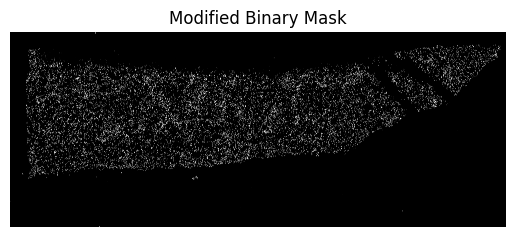

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave, imread
from skimage.measure import label, regionprops

# Assuming binary_mask is your binary mask array, as created previously

# Label connected regions
label_image = label(binary_mask)

# Iterate through the regions and set those with area > 3000 to black. this takes out blobs (of dirt)
for region in regionprops(label_image):
    if region.area > 3000:
        # Set the region to black
        coords = region.coords
        binary_mask[coords[:, 0], coords[:, 1]] = 0
        
# Iterate through the regions and set those with area < 10 to black. This takes out specs (of dirt)
for region in regionprops(label_image):
    if region.area < 10:
        # Set the region to black
        coords = region.coords
        binary_mask[coords[:, 0], coords[:, 1]] = 0


# Save the modified binary mask to a .tiff file
output_file_path = 'R3_HE_modified_binary_mask.tiff'
imsave(output_file_path, (binary_mask.astype(np.uint8) * 255))

# Read the saved .tiff file
loaded_binary_mask = imread(output_file_path) / 255

# Visualize the loaded binary mask
plt.imshow(loaded_binary_mask, cmap='gray')
plt.title("Modified Binary Mask")
plt.axis('off')
plt.show()
